In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pformat

# Prétraitement des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Évaluation des modèles
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from scipy.stats import spearmanr

# Validation croisée et recherche de modèle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

from print_test_results import get_test_results, print_test_results, get_comparison_table
from IPython.display import Markdown

In [2]:
from feature_selection import get_features

# DecisionTreeRegressor

In [3]:
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', None),
    ('selection', None),
    ('model', DecisionTreeRegressor())
])

param_grid = {
    'imputer__strategy': ['constant', 'mean', 'median'],
    'imputer__fill_value': [None],
    'scaler' : [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
    'model__max_depth': range(1, 21),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 11)
}

scoring = {
    'r2' : 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

refit = 'r2'
cv = 5
n_iter = 30

test_results = {
    'fr':{},
    'de':{}
}

## France

In [4]:
data_fr = pd.read_csv('data/Data_FR.csv', index_col='ID')
data_fr.shape

(680, 41)

In [5]:
X = data_fr.drop('TARGET', axis=1)
y = data_fr['TARGET']
X = get_features(X, y, DecisionTreeRegressor())
X.columns

Index(['FR_GAS', 'GAS_RET'], dtype='object')

In [6]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = RandomizedSearchCV(pipeline, param_grid, scoring=scoring,n_iter=n_iter, cv=cv, refit=refit, n_jobs=-1, verbose=1, random_state=42)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

test_results['fr'] = get_test_results(grid_search, X_test, y_test, y_pred)
print_test_results(test_results['fr'], refit, title='DecisionTreeRegressor FR')

Fitting 5 folds for each of 30 candidates, totalling 150 fits

DecisionTreeRegressor FR
 Best estimator: 
  imputer : SimpleImputer(strategy='median')
  scaler : RobustScaler()
  selection : None
  model : DecisionTreeRegressor(max_depth=1, min_samples_split=7)
 Metrics:
  rmse: 1.424
  r2: -0.016
  r2 ajusté: -0.031
  spearman: nan
Wall time: 5.99 s


C:\Users\coren\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


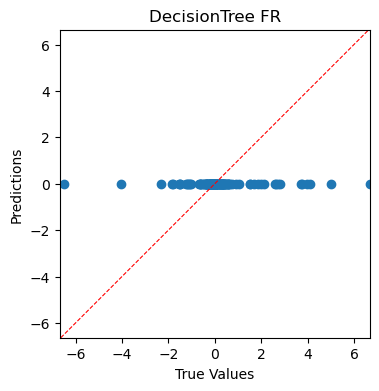

In [7]:
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred)

# x = y (diagonal) red dotted line
plt.axline((0,0), slope=1, color='r', linestyle='--', linewidth=0.8)

plt.axis('equal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('DecisionTree FR');

# Center on (0,0)
yabs_max = abs(max(y_pred, key=abs))
xabs_max = abs(max(y_test, key=abs))
plt.ylim([-yabs_max, yabs_max])
plt.xlim([-xabs_max,xabs_max]);

Text(0.5, 1.0, 'Top 10 Coefficients (DecisionTree FR)')

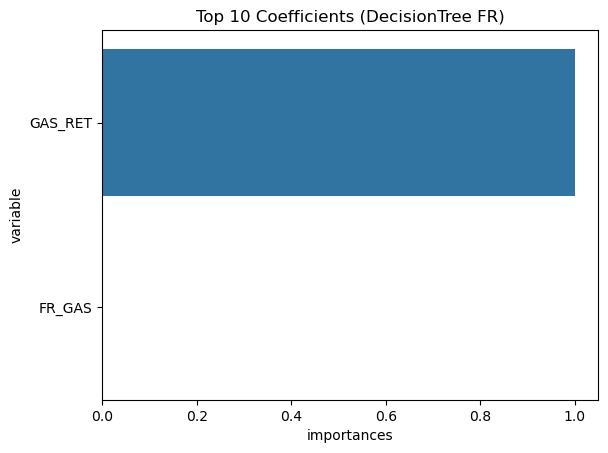

In [8]:
NUM_VAR = 10

coef = grid_search.best_estimator_.named_steps['model'].feature_importances_

coef_df = pd.DataFrame.from_dict({'variable': X.columns, 'importances': coef})
# Trie le DataFrame par valeur absolue des coefficients
coef_df = coef_df.reindex(coef_df.importances.abs().sort_values(ascending=False).index)
# Sélection des `NUM_VAR` premières variables
coef_df = coef_df.head(NUM_VAR).sort_values(by='importances', ascending=False)

sns.barplot(x='importances', y='variable', data=coef_df, color='tab:blue')
plt.title(f'Top {NUM_VAR} Coefficients (DecisionTree FR)')

## Allemagne

In [9]:
data_de = pd.read_csv('data/Data_DE.csv', index_col='ID')
data_de.shape

(596, 41)

In [10]:
X = data_de.drop('TARGET', axis=1)
y = data_de['TARGET']

In [11]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = RandomizedSearchCV(pipeline, param_grid, scoring=scoring, n_iter=n_iter, cv=cv, refit=refit, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

test_results['de'] = get_test_results(grid_search, X_test, y_test, y_pred)
print_test_results(test_results['de'], refit, title='DecisionTreeRegressor DE')

Fitting 5 folds for each of 30 candidates, totalling 150 fits

DecisionTreeRegressor DE
 Best estimator: 
  imputer : SimpleImputer(strategy='median')
  scaler : MinMaxScaler()
  selection : None
  model : DecisionTreeRegressor(max_depth=2, min_samples_leaf=8, min_samples_split=8)
 Metrics:
  rmse: 1.105
  r2: -0.073
  r2 ajusté: -0.616
  spearman: 0.257
Wall time: 1.3 s


Text(0.5, 1.0, 'Top 10 Coefficients (DecisionTree DE)')

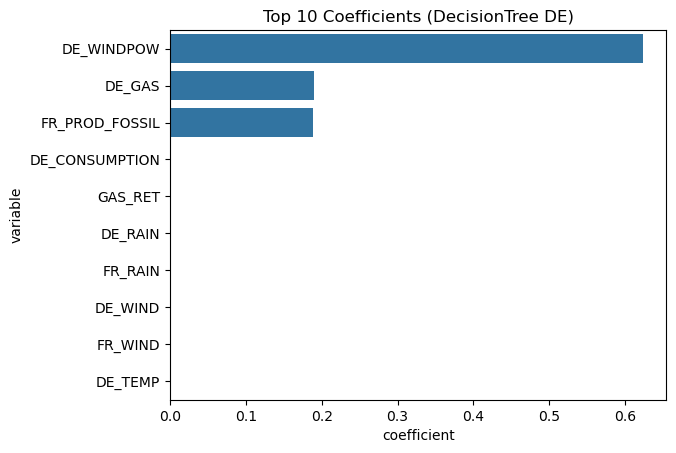

In [12]:
NUM_VAR = 10

coef = grid_search.best_estimator_.named_steps['model'].feature_importances_

coef_df = pd.DataFrame.from_dict({'variable': X.columns, 'coefficient': coef})
# Trie le DataFrame par valeur absolue des coefficients
coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)
# Sélection des `NUM_VAR` premières variables
coef_df = coef_df.head(NUM_VAR).sort_values(by='coefficient', ascending=False)

sns.barplot(x='coefficient', y='variable', data=coef_df, color='tab:blue')
plt.title(f'Top {NUM_VAR} Coefficients (DecisionTree DE)')

# Conclusion

In [13]:
markdown_table = get_comparison_table(test_results, title='DecisionTreeRegressor')
Markdown(markdown_table)

| DecisionTreeRegressor      | FR                                       | DE                                       |
|-------------|--------------------------------------------|--------------------------------------------|
| Imputer     | SimpleImputer(strategy='median')   | SimpleImputer(strategy='median')   |
| Scaler      | RobustScaler()    | MinMaxScaler()    |
| Selection   | None | None |
| Model       | DecisionTreeRegressor(max_depth=1, min_samples_split=7)     | DecisionTreeRegressor(max_depth=2, min_samples_leaf=8, min_samples_split=8)     |
| RMSE        | 1.424               | 1.105               |
| R2          | -0.016                 | -0.073                 |
| R2 ajusté   | -0.031          | -0.616          |
| Spearman    | nan           | 0.257           |